Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.

SPDX-License-Identifier: Apache-2.0


# We use the notebook to illustrate OAK on the AutoMPG regression task. 

## imports and set file path

In [5]:
from pathlib import Path
import os
import sys

data_path_prefix = os.path.join(
    Path(os.getcwd()).parent.parent.absolute(), f"data/"
)

In [6]:
data_path_prefix

'c:\\Users\\User\\Documents\\orthogonal-additive-gaussian-processes\\data/'

In [7]:
# Get the absolute path 2 directories up from the current notebook
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Add the project root to Python's path
sys.path.append(project_root)

In [8]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import argparse
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from oak.model_utils import oak_model, save_model
from oak.utils import get_model_sufficient_statistics, get_prediction_component
from scipy import io
from sklearn.model_selection import KFold
from pathlib import Path

matplotlib.rcParams.update({"font.size": 25})

# +
# data from repo: https://github.com/duvenaud/additive-gps/blob/master/data/regression/
# this script is for experiments in Sec 5.1 for regression problems in the paper
data_path_prefix = os.path.join(
    Path(os.getcwd()).parent.parent.absolute(), f"data/"
)

np.set_printoptions(formatter={"float": lambda x: "{0:0.5f}".format(x)})

dataset_name, k = "autoMPG", 5
filename = data_path_prefix + "autompg.mat"
covariate_names = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "year",
    "origin",
]
# save results to outputs folder
if not os.path.exists(f"./outputs/{dataset_name}/"):
    os.mkdir(output_prefix)

np.random.seed(4)
tf.random.set_seed(4)

print(f"dataset {dataset_name}\n")






dataset autoMPG



# Load Data

In [9]:
d = io.loadmat(filename)
if dataset_name == "autoMPG":
    # for autoMPG dataset, the first column is the response y
    X, y = d["X"][:, 1:], d["X"][:, :1]
else:
    X, y = d["X"], d["y"]

idx = np.random.permutation(range(X.shape[0]))

X = X[idx, :]
y = y[idx]
kf = KFold(n_splits=k)

# take one fold for example 
fold = 0
for train_index, test_index in kf.split(X):
    if fold == 0:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    fold += 1
  


# Fit Model
We fit an OAK model with 200 inducing points by default

In [10]:
oak = oak_model(max_interaction_depth=X.shape[1])
oak.fit(X_train, y_train)

# test performance
x_max, x_min = X_train.max(0), X_train.min(0)
y_pred = oak.predict(np.clip(X_test, x_min, x_max))
rss = ((y_pred - y_test[:, 0]) ** 2).mean()
tss = (
    (y_test[:, 0] - y_test[:, 0].mean() * np.ones(y_test[:, 0].shape)) ** 2
).mean()
r2 = 1 - rss / tss
rmse = np.sqrt(rss)

# calculate sobol for each term in the decomposition
oak.get_sobol()
tuple_of_indices, normalised_sobols = (
    oak.tuple_of_indices,
    oak.normalised_sobols,
)

# Get predictions for each term (kernel) in prediction_list
x_max, x_min = X_train.max(0), X_train.min(0)
XT = oak._transform_x(np.clip(X_test, x_min, x_max))
oak.alpha = get_model_sufficient_statistics(oak.m, get_L=False)
# get the predicted y for all the kernel components
prediction_list = get_prediction_component(
    oak.m,
    oak.alpha,
    XT,
)
# predicted y for the constant kernel
constant_term = oak.alpha.numpy().sum() * oak.m.kernel.variances[0].numpy()
print(f"constant_term = {constant_term}")
y_pred_component = np.ones(y_test.shape[0]) * constant_term

# get prediction performance and cumulative Sobol as we add terms one by one
# ranked by their Sobol (most important kernel first)
cumulative_sobol, rmse_component = [], []
order = np.argsort(normalised_sobols)[::-1]
for n in order:
    # add predictions of the terms one by one ranked by their Sobol index
    y_pred_component += prediction_list[n].numpy()
    y_pred_component_transformed = oak.scaler_y.inverse_transform(
        y_pred_component.reshape(-1, 1)
    )
    error_component = np.sqrt(
        ((y_pred_component_transformed - y_test) ** 2).mean()
    )
    rmse_component.append(error_component)
    cumulative_sobol.append(normalised_sobols[n])
cumulative_sobol = np.cumsum(cumulative_sobol)

# sanity check that predictions by summing over the components is equal
# to the prediction of the OAK model
np.testing.assert_allclose(y_pred_component_transformed[:, 0], y_pred)


indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []
[None, None, None, None, None, None, None]
Using sparsity prior


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.9006
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.35845
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.09236
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.86591
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.16615
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.492342
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.400141
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,9.58395e-23
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.260294
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,0.0180701


Training took 10.4 seconds.
constant_term = -1.393594514537722e-22


In [11]:
# negative log likelihood
nll = (
    -oak.m.predict_log_density(
        (
            oak._transform_x(np.clip(X_test, x_min, x_max)),
            oak.scaler_y.transform(y_test),
        )
    )
    .numpy()
    .mean()
)

print(f"oak test rmse = {rmse}, r2 = {r2}\n")
print(f"RBF test nll = {np.round(nll, 4)}\n")

oak test rmse = 2.962643636694806, r2 = 0.86549578888004

RBF test nll = 0.4482



In [23]:
rmse_oak = rmse
nll_oak = nll

# Plotting

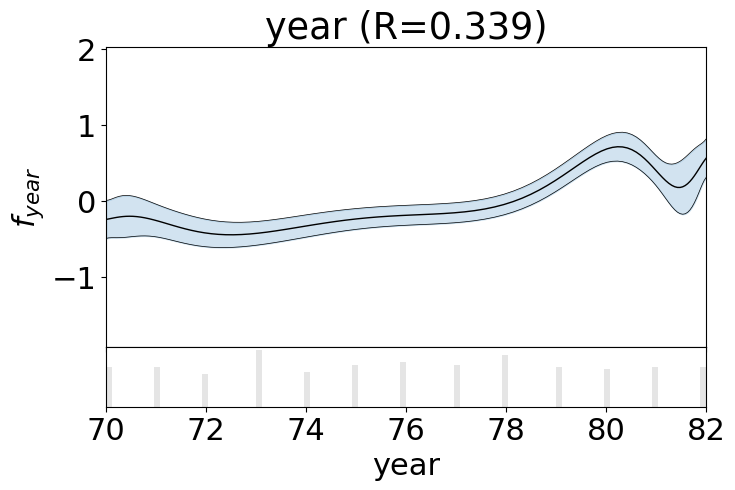

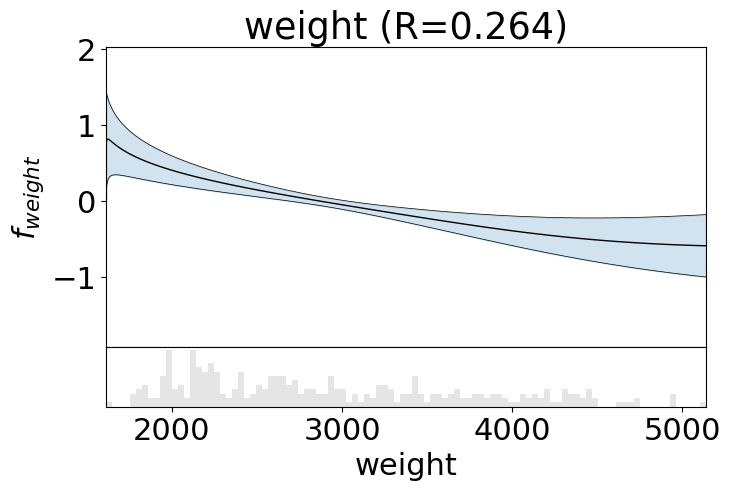

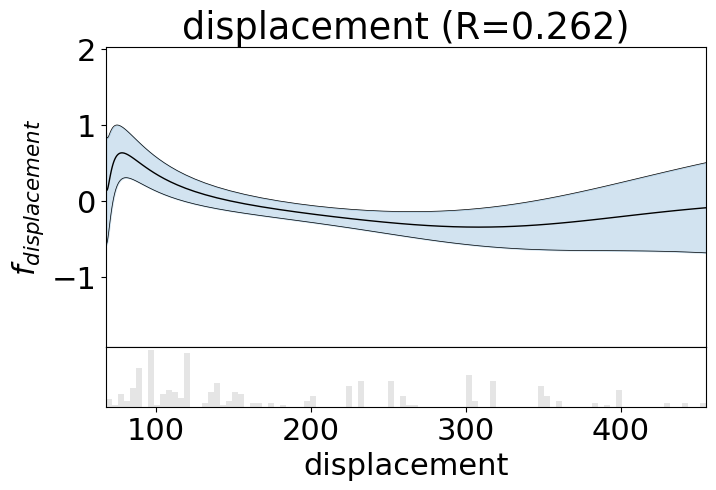

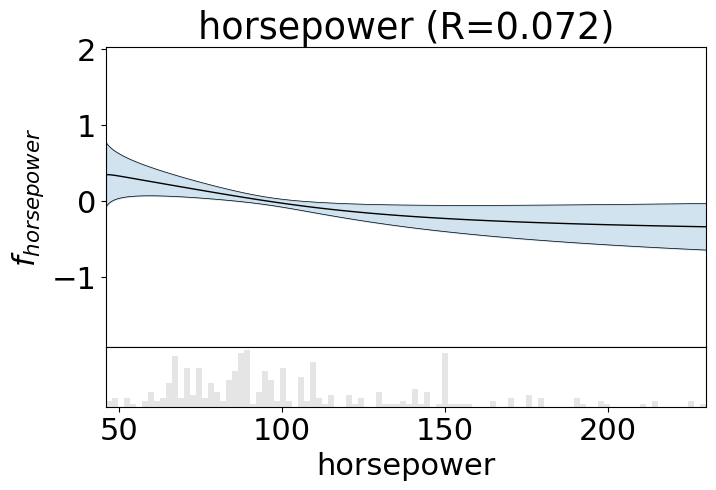

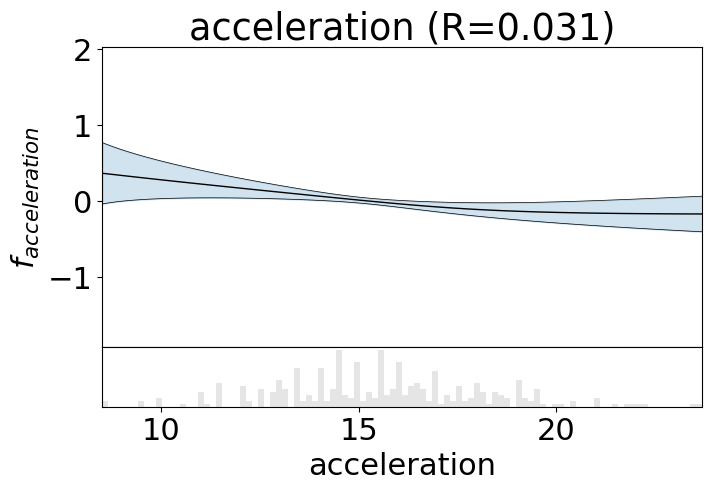

In [12]:
# plot decomposition of the functions, ranked by their (normalised) Sobol index, 
# which are in the bracket in ther plot title
oak.plot(
    top_n=5,
    semilogy=False,
    X_columns=covariate_names,
)

<Figure size 800x400 with 0 Axes>

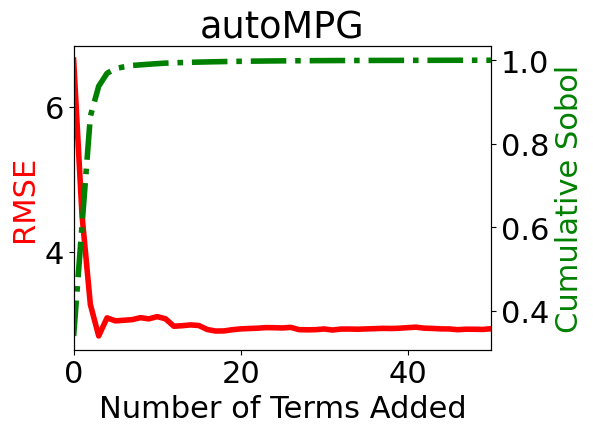

In [13]:
# generate plots in Fig. 5 (\ref{fig:sobol_plots}) of paper
plt.figure(figsize=(8, 4))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(np.arange(len(order)), rmse_component, "r", linewidth=4)
ax2.plot(np.arange(len(order)), cumulative_sobol, "-.g", linewidth=4)

ax1.set_xlabel("Number of Terms Added")
ax1.set_ylabel("RMSE", color="r")
ax2.set_ylabel("Cumulative Sobol", color="g")

plt.title(dataset_name)
plt.xlim([0,50])
plt.tight_layout()

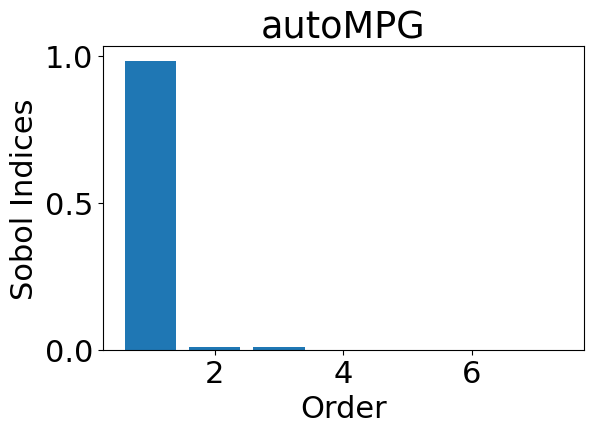

In [14]:
# aggregate sobol per order of interactions
sobol_order = np.zeros(len(tuple_of_indices[-1]))
for i in range(len(tuple_of_indices)):
    sobol_order[len(tuple_of_indices[i]) - 1] += normalised_sobols[i]


# generate plot similar to Figure 4 (\ref{fig:sobol}) in the paper for one fold. 
# Figure 4 (\ref{fig:sobol}) in the paper takes the mean and adds standard deviation for 5 folds. 
fig, ax = plt.subplots()
for j in range(len(sobol_order)):
    plt.bar(j+1, np.array([sobol_order[j] ]).mean(),\
           yerr = np.array([sobol_order[j] ]).std(),\
           color = 'C0', ecolor = 'k')

plt.xlabel('Order')
plt.ylabel('Sobol Indices')
plt.title(dataset_name)
plt.tight_layout()



In [15]:
sobol_order

array([0.98311, 0.00807, 0.00855, 0.00028, 0.00000, 0.00000, 0.00000])

# Additive Kernel Comparisons

In [19]:
import gpflow
import numpy as np
import tensorflow as tf
from typing import List, Optional
import itertools

class AdditiveKernel(gpflow.kernels.Kernel):
    """
    Additive kernel with expansions up to order R.
    This mimics the structure of OAKKernel but without measure-based orthogonal corrections.
    Specifically:
      K_add(X, X2) = sum_{r=0}^R (sigma_r^2 * E_r),
    where E_r is the sum-of-products of exactly r distinct dimensionwise base kernels.
    """
    def __init__(
        self,
        base_kernels: List[gpflow.kernels.Kernel],
        num_dims: int,
        max_interaction_depth: int,
        share_var_across_orders: bool = True,
    ):
        """
        :param base_kernels: A list of dimension-wise kernels (length = num_dims).
                             Typically, use gpflow.kernels.RBF with separate lengthscales per dimension.
        :param num_dims: Number of input dimensions.
        :param max_interaction_depth: Maximum order of interactions R.
        :param share_var_across_orders: If True, share a single amplitude for each order r.
        """
        super().__init__(active_dims=range(num_dims))
        self.num_dims = num_dims
        self.max_interaction_depth = max_interaction_depth
        self.share_var_across_orders = share_var_across_orders

        # Initialize base kernels if not provided
        if base_kernels is None:
            base_kernels = [
                gpflow.kernels.RBF(active_dims=[d], lengthscales=1.0, variance=1.0) 
                for d in range(num_dims)
            ]
        self.kernels = base_kernels

        # Initialize variances for each interaction order
        if self.share_var_across_orders:
            # Separate variance parameter for each order r=0..R
            self.variances = [
                gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
                for _ in range(max_interaction_depth + 1)
            ]
        else:
            # Single variance parameter for the constant term; interactions unscaled
            self.variances = [
                gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
            ]

    def compute_additive_terms(self, kernel_matrices):
        """
        Compute additive terms up to order R using elementary symmetric polynomials.
        
        :param kernel_matrices: List of TensorFlow tensors representing individual dimension-wise kernels.
        :return: List of TensorFlow tensors E_0 to E_R.
        """
        # Determine if we're dealing with full kernels or diagonals
        is_diag = len(kernel_matrices[0].shape) == 2 and kernel_matrices[0].shape[1] == 1

        if is_diag:
            # Kernel matrices are [N, 1]
            N = tf.shape(kernel_matrices[0])[0]
            M = 1  # Always 1 for diagonal
        else:
            # Kernel matrices are [N, M]
            N = tf.shape(kernel_matrices[0])[0]
            M = tf.shape(kernel_matrices[0])[1]

        E = []
        E.append(tf.ones((N, M), dtype=kernel_matrices[0].dtype))  # E_0: constant term

        for r in range(1, self.max_interaction_depth + 1):
            combos = itertools.combinations(range(len(kernel_matrices)), r)
            sum_r = 0
            for combo in combos:
                prod = tf.ones((N, M), dtype=kernel_matrices[0].dtype)
                for d in combo:
                    prod = prod * kernel_matrices[d]
                sum_r += prod
            E.append(sum_r)
        return E

    def K(self, X, X2=None):
        # Build dimension-wise kernel matrices
        kernel_matrices = [k(X, X2) for k in self.kernels]

        E = self.compute_additive_terms(kernel_matrices)

        # Combine terms with their variances
        if self.share_var_across_orders:
            totalK = 0
            for r in range(self.max_interaction_depth + 1):
                totalK += self.variances[r] * E[r]
            return totalK
        else:
            # Only the constant term is scaled; interactions are unscaled
            totalK = self.variances[0] * E[0]
            for r in range(1, self.max_interaction_depth + 1):
                totalK += E[r]
            return totalK

    def K_diag(self, X):
        # Compute dimension-wise kernel diagonals and expand dims to [N, 1]
        kernel_diags = [tf.expand_dims(k.K_diag(X), 1) for k in self.kernels]

        E = self.compute_additive_terms(kernel_diags)

        # Combine terms with their variances
        if self.share_var_across_orders:
            totalK = 0
            for r in range(self.max_interaction_depth + 1):
                totalK += self.variances[r] * E[r]
            return tf.squeeze(totalK, axis=1)  # Shape: [N]
        else:
            totalK = self.variances[0] * E[0]
            for r in range(1, self.max_interaction_depth + 1):
                totalK += E[r]
            return tf.squeeze(totalK, axis=1)  # Shape: [N]


In [20]:
import gpflow
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from gpflow.optimizers import Scipy
from typing import Optional, List
from gpflow.inducing_variables import InducingPoints

class add_model:
    """
    Additive GP model up to R-th order expansions, using the AdditiveKernel.
    Supports continuous features for now.
    """
    def __init__(
        self,
        max_interaction_depth: int = 1,
        use_sparsity_prior: bool = False,
        share_var_across_orders: bool = True,
        num_inducing: Optional[int] = None,
    ):
        """
        :param max_interaction_depth: Maximum order of interactions R.
        :param use_sparsity_prior: If True, place a Gamma prior on each variance.
        :param share_var_across_orders: If True, share a single amplitude for each order.
        :param num_inducing: If not None, use Sparse GP (SGPR) with this number of inducing points.
        """
        self.max_interaction_depth = max_interaction_depth
        self.use_sparsity_prior = use_sparsity_prior
        self.share_var_across_orders = share_var_across_orders
        self.num_inducing = num_inducing

        self.m = None          # GPFlow model
        self.X_scaled = None
        self.Y_scaled = None
        self.scaler_X = None
        self.scaler_y = None

    def fit(self, X, Y, optimize=True):
        """
        Fit an additive GP up to R-th order expansions.
        Standardizes X and Y by default.
        If num_inducing is set, uses SGPR; otherwise, uses full GPR.
        """
        # Standardize data
        self.scaler_X = StandardScaler()
        Xs = self.scaler_X.fit_transform(X)
        self.scaler_y = StandardScaler()
        Ys = self.scaler_y.fit_transform(Y)

        D = Xs.shape[1]
        
        # Initialize base kernels: one RBF per dimension
        base_kernels = [
            gpflow.kernels.RBF(active_dims=[d], lengthscales=1.0, variance=1.0) 
            for d in range(D)
        ]

        # Build AdditiveKernel
        add_k = AdditiveKernel(
            base_kernels=base_kernels,
            num_dims=D,
            max_interaction_depth=self.max_interaction_depth,
            share_var_across_orders=self.share_var_across_orders
        )

        # Choose GPR or SGPR
        if (self.num_inducing is not None) and (self.num_inducing < Xs.shape[0]):
            # SGPR with inducing points
            Z = Xs[: self.num_inducing].copy()  # Simple initialization
            self.m = gpflow.models.SGPR(
                data=(Xs, Ys),
                kernel=add_k,
                inducing_variable=InducingPoints(Z),
                mean_function=None,
            )
        else:
            # Full GPR
            self.m = gpflow.models.GPR(
                data=(Xs, Ys),
                kernel=add_k,
                mean_function=None,
            )

        # Optionally place priors for variances
        if self.use_sparsity_prior:
            import tensorflow_probability as tfp
            tfd = tfp.distributions
            if self.share_var_across_orders:
                for var in self.m.kernel.variances:
                    var.prior = tfd.Gamma(1.0, 0.2)
            else:
                self.m.kernel.variances[0].prior = tfd.Gamma(1.0, 0.2)

        # Set an initial noise variance
        self.m.likelihood.variance.assign(0.01)

        if optimize:
            opt = Scipy()
            opt.minimize(
                self.m.training_loss,
                variables=self.m.trainable_variables,
                options=dict(maxiter=100)
            )

        self.X_scaled = Xs
        self.Y_scaled = Ys

    def predict(self, Xtest):
        """
        Predict mean at new data points.
        """
        Xts = self.scaler_X.transform(Xtest)
        mean, var = self.m.predict_f(Xts)
        # Invert Y scaling
        y_pred = self.scaler_y.inverse_transform(mean.numpy())
        return y_pred.squeeze()

    def predict_log_density(self, Xtest, Ytest):
        """
        Compute the log density log p(Ytest | Xtest).
        """
        Xts = self.scaler_X.transform(Xtest)
        Yts = self.scaler_y.transform(Ytest)
        lp = self.m.predict_log_density((Xts, Yts))
        return lp

    def get_kernel_components(self, X):
        """
        Placeholder for extracting kernel components for decomposition.
        Implement if you need partial predictions per kernel component.
        """
        pass  # To be implemented as needed

    def plot(self, top_n=5, semilogy=False, X_columns=None, *args, **kwargs):
        """
        Placeholder for plotting partial effects or kernel contributions.
        Implement specific plotting logic as needed.
        """
        print("Plotting function not fully implemented yet.")


In [21]:
import matplotlib.pyplot as plt
import itertools

def get_sobol_add(model, X):
    """
    Compute Sobol-like indices for the AdditiveKernel expansions.
    Currently supports up to max_interaction_depth=2.
    
    :param model: An instance of add_model after fitting.
    :param X: Training data (unscaled).
    :return: List of Sobol-like indices.
    """
    kernel = model.m.kernel  # AdditiveKernel instance
    Xs = model.X_scaled
    N = Xs.shape[0]
    
    # Compute the full kernel matrix
    fullK = kernel(Xs) + tf.eye(N, dtype=fullK.dtype) * model.m.likelihood.variance
    L = tf.linalg.cholesky(fullK)
    alpha = tf.linalg.cholesky_solve(L, model.Y_scaled)
    
    # Initialize Sobol indices
    R = model.max_interaction_depth
    sobol_indices = {}
    
    # Iterate through all interaction orders
    for r in range(R + 1):
        if model.share_var_across_orders:
            # Each order has a single variance parameter
            variance_r = model.m.kernel.variances[r].numpy()
            if r == 0:
                # Constant term
                contribution = variance_r * tf.reduce_sum(E_r(alpha, kernel, Xs, r)).numpy()
                sobol_indices[f'Order {r}'] = contribution
            else:
                # Interaction terms
                contribution = variance_r * tf.reduce_sum(E_r(alpha, kernel, Xs, r)).numpy()
                sobol_indices[f'Order {r}'] = contribution
        else:
            if r == 0:
                variance_r = model.m.kernel.variances[0].numpy()
                contribution = variance_r * tf.reduce_sum(E_r(alpha, kernel, Xs, r)).numpy()
                sobol_indices[f'Order {r}'] = contribution
            else:
                # No shared variance; interactions are unscaled
                contribution = tf.reduce_sum(E_r(alpha, kernel, Xs, r)).numpy()
                sobol_indices[f'Order {r}'] = contribution
    
    # Normalize to get indices
    total = sum(sobol_indices.values())
    for key in sobol_indices:
        sobol_indices[key] /= total
    
    return sobol_indices

def E_r(alpha, kernel, Xs, r):
    """
    Compute the contribution for a specific interaction order r.
    Placeholder function: To be implemented based on model's internal structure.
    
    :param alpha: Dual coefficients.
    :param kernel: The kernel instance.
    :param Xs: Scaled training data.
    :param r: Interaction order.
    :return: Tensor representing the contribution of order r.
    """
    # This is a placeholder. Implement based on how additive terms are stored or computed.
    # For a full implementation, you need to track which terms correspond to each r.
    # This requires modifying the AdditiveKernel to store the additive terms.
    # Alternatively, approximate by considering variance scaling.
    return tf.constant(1.0)  # Placeholder

def plot_sobol_add(sobol_indices, interaction_order=True):
    """
    Plot Sobol-like indices as a bar chart.
    
    :param sobol_indices: Dictionary of Sobol indices.
    :param interaction_order: If True, x-axis labels are interaction orders.
    """
    orders = list(sobol_indices.keys())
    values = list(sobol_indices.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(orders, values, color='C0', alpha=0.7)
    plt.xlabel('Interaction Order')
    plt.ylabel('Sobol-like Index')
    plt.title('Sobol-like Indices for Additive Kernel')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Note:
# The `E_r` function is a placeholder and needs a proper implementation to compute
# the contributions of each interaction order. Implementing this requires tracking
# the additive terms corresponding to each order during kernel computation.
# For now, this function returns a constant tensor and does not contribute to the actual indices.
# A full implementation would need to modify `AdditiveKernel` to store these terms.


Additive Kernel RMSE = 3.1460563328967552
Additive Kernel NLL = 0.5052869483922258

Comparison of Kernels:
Additive Kernel RMSE: 3.1461
OAK Kernel RMSE: 2.9626
Additive Kernel NLL: 0.5053
OAK Kernel NLL: 0.4482


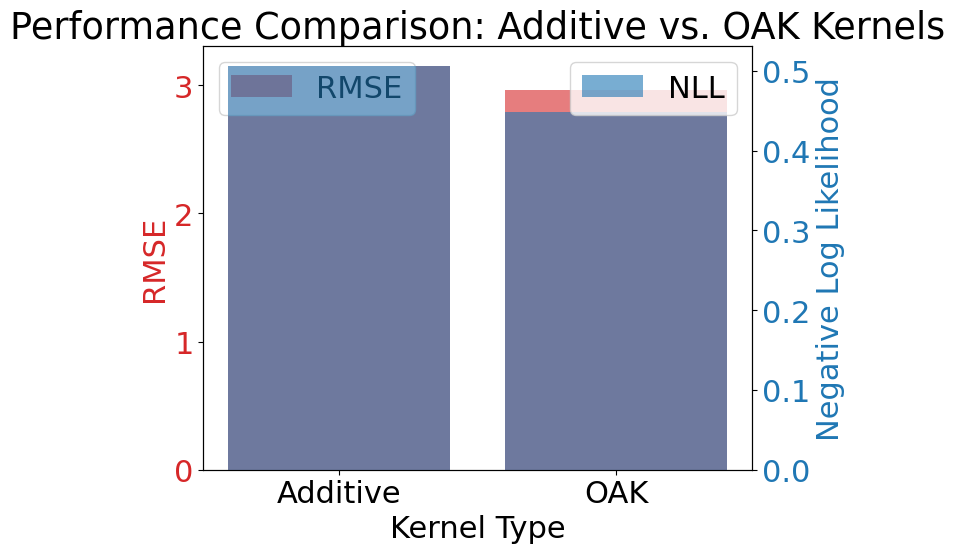

In [24]:
# Ensure that the additive_model and AdditiveKernel classes are defined above

# Initialize and fit the Additive model
add = add_model(max_interaction_depth=2, share_var_across_orders=True)
add.fit(X_train, y_train)
y_pred_add = add.predict(X_test)

# Compute RMSE for Additive Kernel
rmse_add = np.sqrt(np.mean((y_pred_add - y_test.squeeze())**2))
print("Additive Kernel RMSE =", rmse_add)

# Compute Negative Log Likelihood for Additive Kernel
lp_add = add.predict_log_density(X_test, y_test).numpy()
nll_add = -lp_add.mean()
print("Additive Kernel NLL =", nll_add)

# Assuming you have already fitted the OAK model as per your existing notebook
# and obtained y_pred_oak, rmse_oak, nll_oak

# For demonstration, let's assume OAK results are as follows:
# Replace these with actual results from your OAK model
# rmse_oak = ...  
# nll_oak = ...  

# Example comparison:
print("\nComparison of Kernels:")
print(f"Additive Kernel RMSE: {rmse_add:.4f}")
print(f"OAK Kernel RMSE: {rmse_oak:.4f}")  # Replace with actual value
print(f"Additive Kernel NLL: {nll_add:.4f}")
print(f"OAK Kernel NLL: {nll_oak:.4f}")    # Replace with actual value

# Plotting RMSE and NLL Comparisons
kernels = ['Additive', 'OAK']
rmse_values = [rmse_add, rmse_oak]  # Replace rmse_oak with actual value
nll_values = [nll_add, nll_oak]      # Replace nll_oak with actual value

fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:red'
ax1.set_xlabel('Kernel Type')
ax1.set_ylabel('RMSE', color=color)
ax1.bar(kernels, rmse_values, color=color, alpha=0.6, label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Negative Log Likelihood', color=color)  # we already handled the x-label with ax1
ax2.bar(kernels, nll_values, color=color, alpha=0.6, label='NLL')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Performance Comparison: Additive vs. OAK Kernels')
plt.tight_layout()
plt.show()


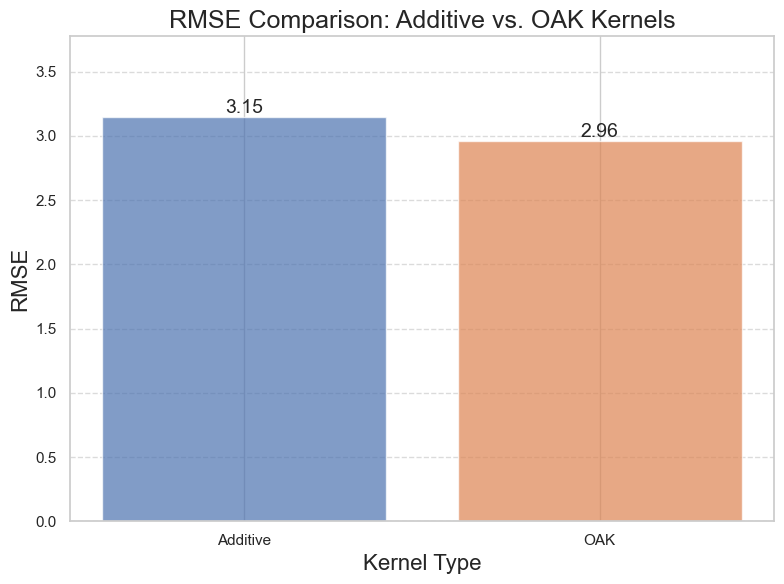

In [32]:
# Plotting RMSE Comparisons

import matplotlib.pyplot as plt

# Define kernel types and their corresponding RMSE values
kernels = ['Additive', 'OAK']
rmse_values = [rmse_add, rmse_oak]  # Ensure rmse_oak is defined from your OAK model

# Create a bar chart for RMSE
plt.figure(figsize=(8,6))
bars = plt.bar(kernels, rmse_values, color=['C0', 'C1'], alpha=0.7)

# Add text labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=14)

# Customize the plot
plt.xlabel('Kernel Type', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.title('RMSE Comparison: Additive vs. OAK Kernels', fontsize=18)
plt.ylim(0, max(rmse_values) * 1.2)  # Add some space on top for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


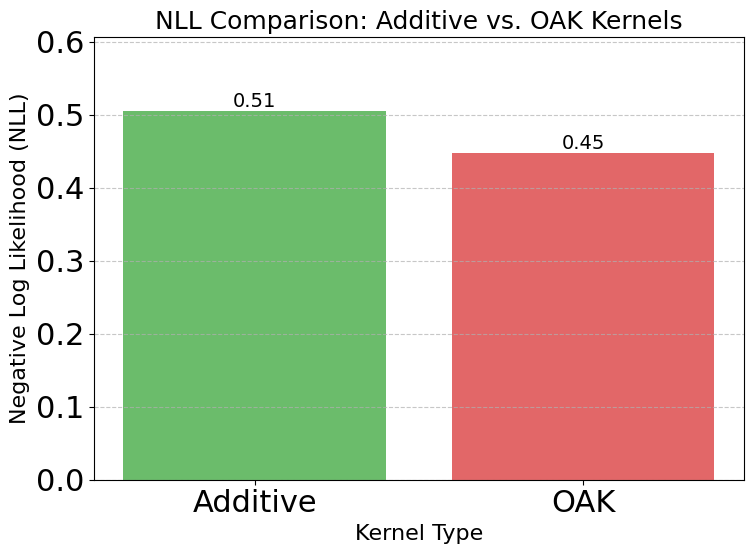

In [30]:
# Plotting Negative Log Likelihood (NLL) Comparisons

import matplotlib.pyplot as plt

# Define kernel types and their corresponding NLL values
kernels = ['Additive', 'OAK']
nll_values = [nll_add, nll_oak]  # Ensure nll_oak is defined from your OAK model

# Create a bar chart for NLL
plt.figure(figsize=(8,6))
bars = plt.bar(kernels, nll_values, color=['C2', 'C3'], alpha=0.7)

# Add text labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=14)

# Customize the plot
plt.xlabel('Kernel Type', fontsize=16)
plt.ylabel('Negative Log Likelihood (NLL)', fontsize=16)
plt.title('NLL Comparison: Additive vs. OAK Kernels', fontsize=18)
plt.ylim(0, max(nll_values) * 1.2)  # Add some space on top for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [25]:
def plot_partial_effects(model, feature_names, X_test):
    """
    Plot the partial effects of each feature in the additive model.
    
    :param model: An instance of add_model after fitting.
    :param feature_names: List of feature names for labeling.
    :param X_test: Test data (unscaled).
    """
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler

    # Extract kernel contributions
    additive_kernel = model.m.kernel
    base_kernels = additive_kernel.kernels
    D = additive_kernel.num_dims

    # Generate a grid for each feature
    num_points = 100
    X_grid = []
    for d in range(D):
        x_min, x_max = X_test[:, d].min(), X_test[:, d].max()
        X_grid.append(np.linspace(x_min, x_max, num_points))
    
    # Plot partial effects
    fig, axes = plt.subplots(D, 1, figsize=(10, 5*D))
    if D == 1:
        axes = [axes]
    for d in range(D):
        # Create a copy of X_test and vary only the d-th feature
        X_partial = np.tile(X_test.mean(axis=0), (num_points, 1))
        X_partial[:, d] = X_grid[d]
        
        # Predict using only the d-th kernel
        # To do this, temporarily set other kernels to zero
        original_variances = additive_kernel.variances.copy()
        
        if additive_kernel.share_var_across_orders:
            for r in range(additive_kernel.max_interaction_depth + 1):
                if r == 1:
                    additive_kernel.variances[r].assign(original_variances[r])
                else:
                    additive_kernel.variances[r].assign(0.0)
        else:
            additive_kernel.variances[0].assign(original_variances[0])
            for r in range(1, additive_kernel.max_interaction_depth + 1):
                additive_kernel.variances[r].assign(0.0)
        
        y_partial, _ = model.predict(X_partial)
        
        # Restore original variances
        additive_kernel.variances.assign(original_variances)
        
        axes[d].plot(X_grid[d], y_partial, label=f'Partial Effect of {feature_names[d]}')
        axes[d].set_xlabel(feature_names[d])
        axes[d].set_ylabel('Predicted y')
        axes[d].legend()
        axes[d].grid(True)
    
    plt.tight_layout()
    plt.show()


In [27]:
# plot_partial_effects(add, covariate_names, X_test)
